In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import acquire
from prepare import prep_telco
from env import host, user, password
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
def get_connection(db, user=user, host=host, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def new_telco_data():
    sql_query = 'SELECT customers.*, contract_types.contract_type, internet_service_types.internet_service_type, payment_types.payment_type FROM customers JOIN contract_types using(contract_type_id) JOIN internet_service_types using(internet_service_type_id) JOIN payment_types using(payment_type_id) '
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    df.to_csv('telco_churn_df.csv')
    return df

In [3]:
acquire

<module 'acquire' from '/Users/matthewknight/telco_project/acquire.py'>

In [4]:
df = new_telco_data()

In [5]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,Yes,1,Yes,4,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,No,1,Yes,1,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,No,1,Yes,1,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,No,1,No,3,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [8]:
telco = df.drop(columns=['customer_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'internet_service_type_id', 'contract_type_id', 'payment_type_id'])

In [9]:
telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Male,0,No,No,9,Yes,Yes,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,Female,0,No,Yes,9,Yes,No,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,Female,1,No,No,7,Yes,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,Male,1,No,No,1,No,No phone service,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,Female,0,Yes,Yes,1,No,No phone service,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [10]:
# for col in telco.columns:
#     plt.figure(figsize=(4,3))
#     plt.hist(telco[col])
#     plt.title(col)
#     plt.show()

In [11]:
telco = telco.drop(columns=['partner', 'dependents', 'multiple_lines', 'streaming_tv', 'streaming_movies', 'total_charges'])

In [12]:
telco.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,contract_type,internet_service_type,payment_type
0,Male,0,9,Yes,No,59.9,No,Month-to-month,DSL,Mailed check
1,Female,0,9,Yes,Yes,69.4,No,Month-to-month,DSL,Credit card (automatic)
2,Female,1,7,Yes,Yes,48.2,No,Month-to-month,DSL,Electronic check
3,Male,1,1,No,Yes,25.1,Yes,Month-to-month,DSL,Electronic check
4,Female,0,1,No,No,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [13]:
telco_dummies = pd.get_dummies(telco.contract_type)


In [14]:
telco = pd.concat([telco, telco_dummies], axis=1)


In [15]:
telco.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,contract_type,internet_service_type,payment_type,Month-to-month,One year,Two year
0,Male,0,9,Yes,No,59.9,No,Month-to-month,DSL,Mailed check,1,0,0
1,Female,0,9,Yes,Yes,69.4,No,Month-to-month,DSL,Credit card (automatic),1,0,0
2,Female,1,7,Yes,Yes,48.2,No,Month-to-month,DSL,Electronic check,1,0,0
3,Male,1,1,No,Yes,25.1,Yes,Month-to-month,DSL,Electronic check,1,0,0
4,Female,0,1,No,No,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic),1,0,0


In [16]:
telco = telco.drop(columns='contract_type')

In [17]:
telco_dummies = pd.get_dummies(telco.internet_service_type)


In [18]:
telco = pd.concat([telco, telco_dummies], axis=1)


In [19]:
telco = telco.drop(columns='internet_service_type')

In [20]:
telco.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,payment_type,Month-to-month,One year,Two year,DSL,Fiber optic,None
0,Male,0,9,Yes,No,59.9,No,Mailed check,1,0,0,1,0,0
1,Female,0,9,Yes,Yes,69.4,No,Credit card (automatic),1,0,0,1,0,0
2,Female,1,7,Yes,Yes,48.2,No,Electronic check,1,0,0,1,0,0
3,Male,1,1,No,Yes,25.1,Yes,Electronic check,1,0,0,1,0,0
4,Female,0,1,No,No,30.5,Yes,Bank transfer (automatic),1,0,0,1,0,0


In [21]:
telco_dummies = pd.get_dummies(telco.payment_type)


In [22]:
telco = pd.concat([telco, telco_dummies], axis=1)


In [23]:
telco = telco.drop(columns='payment_type')

In [24]:
telco.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,Male,0,9,Yes,No,59.9,No,1,0,0,1,0,0,0,0,0,1
1,Female,0,9,Yes,Yes,69.4,No,1,0,0,1,0,0,0,1,0,0
2,Female,1,7,Yes,Yes,48.2,No,1,0,0,1,0,0,0,0,1,0
3,Male,1,1,No,Yes,25.1,Yes,1,0,0,1,0,0,0,0,1,0
4,Female,0,1,No,No,30.5,Yes,1,0,0,1,0,0,1,0,0,0


In [28]:
telco.loc[telco['phone_service'] == 'No', 'phone_service'] = 0

In [29]:
telco.loc[telco['phone_service'] == 'Yes', 'phone_service'] = 1

In [30]:
telco.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,Male,0,9,1,No,59.9,No,1,0,0,1,0,0,0,0,0,1
1,Female,0,9,1,Yes,69.4,No,1,0,0,1,0,0,0,1,0,0
2,Female,1,7,1,Yes,48.2,No,1,0,0,1,0,0,0,0,1,0
3,Male,1,1,0,Yes,25.1,Yes,1,0,0,1,0,0,0,0,1,0
4,Female,0,1,0,No,30.5,Yes,1,0,0,1,0,0,1,0,0,0


In [31]:
telco.loc[telco['paperless_billing'] == 'No', 'paperless_billing'] = 0

In [32]:
telco.loc[telco['paperless_billing'] == 'Yes', 'paperless_billing'] = 1

In [33]:
telco.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,Male,0,9,1,0,59.9,No,1,0,0,1,0,0,0,0,0,1
1,Female,0,9,1,1,69.4,No,1,0,0,1,0,0,0,1,0,0
2,Female,1,7,1,1,48.2,No,1,0,0,1,0,0,0,0,1,0
3,Male,1,1,0,1,25.1,Yes,1,0,0,1,0,0,0,0,1,0
4,Female,0,1,0,0,30.5,Yes,1,0,0,1,0,0,1,0,0,0


In [34]:
telco.loc[telco['churn'] == 'No', 'churn'] = 0

In [35]:
telco.loc[telco['churn'] == 'Yes', 'churn'] = 1

In [36]:
telco.head(10)

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,Male,0,9,1,0,59.90,0,1,0,0,1,0,0,0,0,0,1
1,Female,0,9,1,1,69.40,0,1,0,0,1,0,0,0,1,0,0
2,Female,1,7,1,1,48.20,0,1,0,0,1,0,0,0,0,1,0
3,Male,1,1,0,1,25.10,1,1,0,0,1,0,0,0,0,1,0
4,Female,0,1,0,0,30.50,1,1,0,0,1,0,0,1,0,0,0
5,Male,1,2,1,1,49.25,1,1,0,0,1,0,0,0,0,1,0
6,Male,0,29,0,1,45.00,0,1,0,0,1,0,0,0,0,0,1
7,Male,0,1,1,1,44.30,0,1,0,0,1,0,0,0,0,0,1
8,Female,0,6,1,0,50.35,0,1,0,0,1,0,0,0,0,1,0
9,Male,0,30,1,1,64.50,0,1,0,0,1,0,0,0,0,0,1


In [37]:
telco_dummies = pd.get_dummies(telco.gender)


In [38]:
telco = pd.concat([telco, telco_dummies], axis=1)


In [39]:
telco.drop(columns='gender')

,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
0,0,9,1,0,59.90,0,1,0,0,1,0,0,0,0,0,1,0,1
1,0,9,1,1,69.40,0,1,0,0,1,0,0,0,1,0,0,1,0
2,1,7,1,1,48.20,0,1,0,0,1,0,0,0,0,1,0,1,0
3,1,1,0,1,25.10,1,1,0,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,30.50,1,1,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,28,1,1,20.30,0,0,0,1,0,0,1,0,1,0,0,0,1
7039,0,63,1,0,25.25,0,0,0,1,0,0,1,0,0,0,1,0,1
7040,0,71,1,1,24.40,0,0,0,1,0,0,1,0,1,0,0,1,0
7041,0,67,1,1,19.25,0,0,0,1,0,0,1,1,0,0,0,1,0


In [40]:
telco.isnull().sum()

gender                       0
senior_citizen               0
tenure                       0
phone_service                0
paperless_billing            0
monthly_charges              0
churn                        0
Month-to-month               0
One year                     0
Two year                     0
DSL                          0
Fiber optic                  0
None                         0
Bank transfer (automatic)    0
Credit card (automatic)      0
Electronic check             0
Mailed check                 0
Female                       0
Male                         0
dtype: int64

In [43]:
import prepare

In [44]:
train, validate, test = telco_split(telco)


NameError: name 'telco_split' is not defined

In [45]:
def telco_split(df):

    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123,
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3,
                                        random_state=123,
                                        stratify=train_validate.churn)
    return train, validate, test

In [46]:
train, validate, test = telco_split(telco)


In [47]:
train.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
5670,Male,0,5,1,0,20.35,0,1,0,0,0,0,1,0,1,0,0,0,1
4152,Female,0,6,1,1,89.25,0,1,0,0,0,1,0,0,0,1,0,1,0
4890,Male,0,54,1,0,84.40,0,0,1,0,0,1,0,0,0,1,0,0,1
2391,Female,0,72,1,0,64.75,0,0,0,1,1,0,0,1,0,0,0,1,0
2896,Male,0,28,1,0,76.55,0,1,0,0,0,1,0,1,0,0,0,0,1


In [48]:
telco = telco.drop(columns='gender')

In [49]:
train, validate, test = telco_split(telco)


In [50]:
train.head()

,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
5670,0,5,1,0,20.35,0,1,0,0,0,0,1,0,1,0,0,0,1
4152,0,6,1,1,89.25,0,1,0,0,0,1,0,0,0,1,0,1,0
4890,0,54,1,0,84.40,0,0,1,0,0,1,0,0,0,1,0,0,1
2391,0,72,1,0,64.75,0,0,0,1,1,0,0,1,0,0,0,1,0
2896,0,28,1,0,76.55,0,1,0,0,0,1,0,1,0,0,0,0,1


In [56]:
train.churn.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

In [78]:
########## BASELINE ############

In [77]:
2897 / (2897 + 1046)

0.7347197565305605

In [79]:
1046 / (2897 + 1046)

0.2652802434694395

In [51]:
logit = LogisticRegression()


In [54]:
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [55]:
logit = logit.fit(X_train, y_train)


ValueError: Unknown label type: 'unknown'

In [59]:
telco.dtypes

senior_citizen                 int64
tenure                         int64
phone_service                 object
paperless_billing             object
monthly_charges              float64
churn                         object
Month-to-month                 uint8
One year                       uint8
Two year                       uint8
DSL                            uint8
Fiber optic                    uint8
None                           uint8
Bank transfer (automatic)      uint8
Credit card (automatic)        uint8
Electronic check               uint8
Mailed check                   uint8
Female                         uint8
Male                           uint8
dtype: object

In [62]:
telco['churn'] = telco.churn.astype('int')

In [63]:
telco.dtypes

senior_citizen                 int64
tenure                         int64
phone_service                 object
paperless_billing             object
monthly_charges              float64
churn                          int64
Month-to-month                 uint8
One year                       uint8
Two year                       uint8
DSL                            uint8
Fiber optic                    uint8
None                           uint8
Bank transfer (automatic)      uint8
Credit card (automatic)        uint8
Electronic check               uint8
Mailed check                   uint8
Female                         uint8
Male                           uint8
dtype: object

In [64]:
telco['phone_service'] = telco.phone_service.astype('int')

In [65]:
telco['paperless_billing'] = telco.paperless_billing.astype('int')

In [66]:
train, validate, test = telco_split(telco)


In [67]:
logit = LogisticRegression()


In [68]:
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [69]:
logit = logit.fit(X_train, y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [70]:
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)

In [71]:
logit.score(X_train, y_train)


0.8001521683996957

In [72]:
print(logit.coef_)


[[ 0.1469971  -0.03480605 -0.79458373  0.39560951  0.01047071  0.60478486
  -0.02170918 -1.03169191 -0.36322252  0.54330592 -0.62869962 -0.14365406
  -0.23866299  0.15270431 -0.21900348 -0.21443408 -0.23418214]]


In [73]:
train.columns

Index(['senior_citizen', 'tenure', 'phone_service', 'paperless_billing',
       'monthly_charges', 'churn', 'Month-to-month', 'One year', 'Two year',
       'DSL', 'Fiber optic', 'None', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check', 'Female',
       'Male'],
      dtype='object')

In [74]:
X_train2 = train[['phone_service', 'Month-to-month', 'One year', 'Two year']]
y_train = train.churn

In [75]:
logit2 = LogisticRegression()
logit2 = logit2.fit(X_train2, y_train)

print(logit2.coef_)
print(X_train2.columns)


[[ 0.06795031  1.6236104  -0.02360575 -1.60071497]]
Index(['phone_service', 'Month-to-month', 'One year', 'Two year'], dtype='object')


In [76]:
logit2.score(X_train2, y_train)


0.7347197565305605

In [80]:
###Matches baseline###

In [83]:
X_train3 = train[['Bank transfer (automatic)', 'Electronic check', 'Credit card (automatic)', 'Mailed check']]
y_train = train.churn

In [84]:
logit3 = LogisticRegression()
logit3 = logit3.fit(X_train3, y_train)

print(logit3.coef_)
print(X_train3.columns)

[[-0.25060524  0.98739834 -0.49534751 -0.24169387]]
Index(['Bank transfer (automatic)', 'Electronic check',
       'Credit card (automatic)', 'Mailed check'],
      dtype='object')


In [91]:
logit3.score(X_train3, y_train)


0.7347197565305605

In [95]:
X_train4 = train[['Bank transfer (automatic)', 'Credit card (automatic)']]
y_train = train.churn

In [96]:
logit4 = LogisticRegression()
logit4 = logit4.fit(X_train4, y_train)

print(logit4.coef_)
print(X_train4.columns)

[[-0.79230716 -1.03614483]]
Index(['Bank transfer (automatic)', 'Credit card (automatic)'], dtype='object')


In [97]:
logit4.score(X_train4, y_train)


0.7347197565305605

In [99]:
from sklearn.tree import DecisionTreeClassifier

In [100]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)


In [108]:
X_train

,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
5670,0,5,1,0,20.35,1,0,0,0,0,1,0,1,0,0,0,1
4152,0,6,1,1,89.25,1,0,0,0,1,0,0,0,1,0,1,0
4890,0,54,1,0,84.40,0,1,0,0,1,0,0,0,1,0,0,1
2391,0,72,1,0,64.75,0,0,1,1,0,0,1,0,0,0,1,0
2896,0,28,1,0,76.55,1,0,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,0,66,1,1,104.05,0,1,0,0,1,0,0,0,1,0,0,1
381,1,51,0,1,29.45,1,0,0,1,0,0,0,1,0,0,0,1
2622,0,7,1,0,74.65,1,0,0,0,1,0,0,0,0,1,0,1
3812,0,60,1,1,106.15,1,0,0,0,1,0,0,0,1,0,1,0


In [101]:
clf.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [102]:
y_pred = clf.predict(X_train)


In [103]:
y_pred_proba = clf.predict_proba(X_train)


In [104]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [105]:
confusion_matrix(y_train, y_pred)


array([[2717,  180],
       [ 647,  399]])

In [106]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2897
           1       0.69      0.38      0.49      1046

    accuracy                           0.79      3943
   macro avg       0.75      0.66      0.68      3943
weighted avg       0.78      0.79      0.77      3943



In [107]:
y_train

5670    0
4152    0
4890    0
2391    0
2896    0
       ..
4758    1
381     0
2622    1
3812    0
6867    0
Name: churn, Length: 3943, dtype: int64

In [109]:
clf.fit(X_train4, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [111]:
y_pred = clf.predict(X_train4)

In [113]:
y_pred_proba = clf.predict_proba(X_train4)


In [115]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train4, y_train)))

Accuracy of Decision Tree classifier on training set: 0.73


In [116]:
clf.fit(X_train3, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [118]:
y_pred = clf.predict(X_train3)


In [119]:
y_pred_proba = clf.predict_proba(X_train3)


In [120]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train3, y_train)))

Accuracy of Decision Tree classifier on training set: 0.73


In [123]:
X_train6 = train[[ 'tenure']]
y_train = train.churn

In [128]:
logit6 = LogisticRegression()
logit6 = logit6.fit(X_train6, y_train)

print(logit6.coef_)
print(X_train6.columns)

[[-0.03781409]]
Index(['tenure'], dtype='object')


In [129]:
y_pred = logit6.predict(X_train6)
y_pred_proba = logit6.predict_proba(X_train6)

In [130]:
logit6.score(X_train6, y_train)


0.7347197565305605

In [131]:
df = new_telco_data()

In [132]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,Yes,1,Yes,4,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,No,1,Yes,1,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,No,1,Yes,1,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,No,1,No,3,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


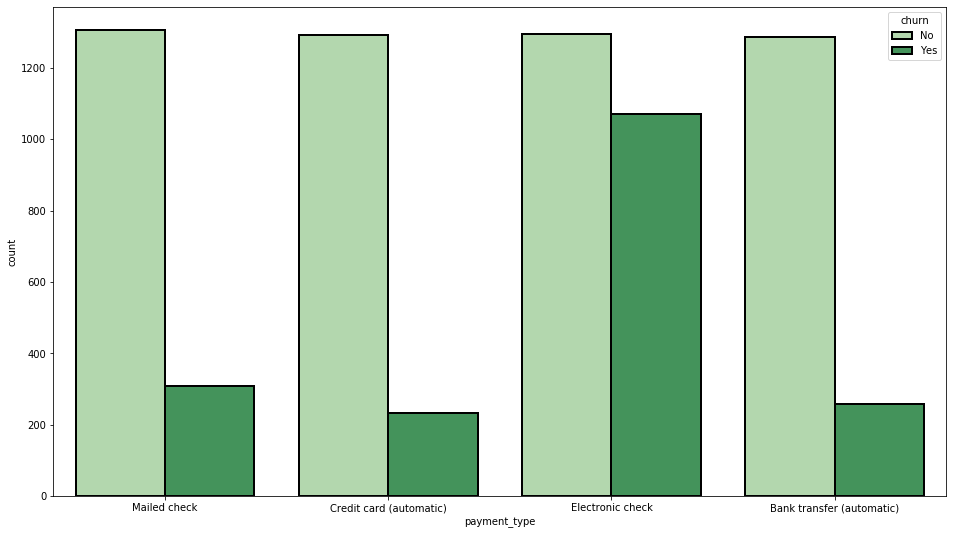

In [138]:
plt.rc('figure',figsize=(16,9))
sns.countplot(x = 'payment_type', hue = 'churn', data=df, palette='Greens', ec='black', linewidth=2)

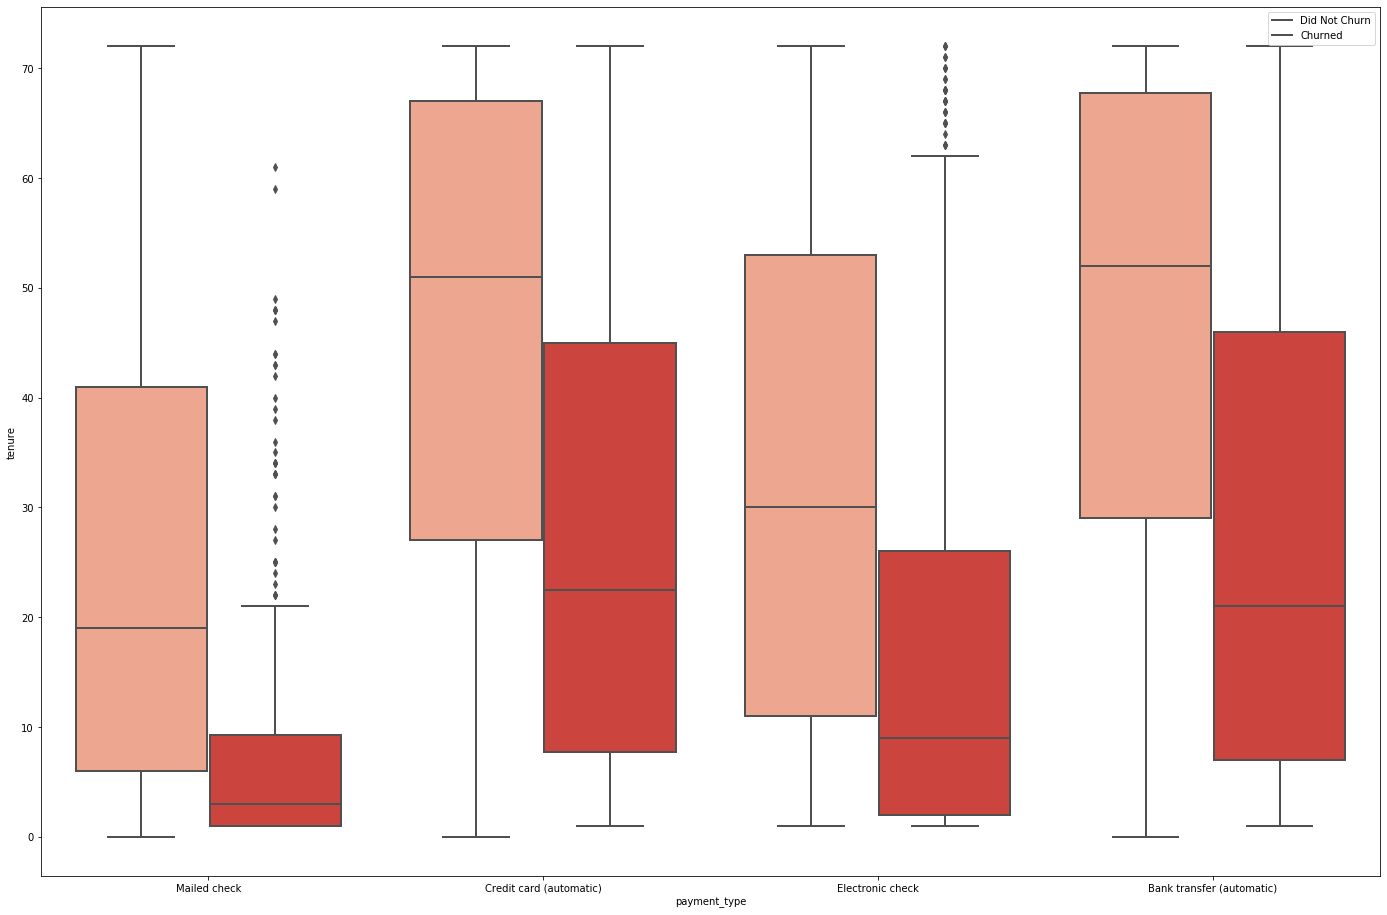

In [146]:
plt.rc('figure',figsize=(24,16))

sns.boxplot(x='payment_type', y='tenure', data=df, hue='churn', palette='Reds', linewidth=2)
plt.legend(['Did Not Churn', 'Churned'])
plt.show()

In [159]:
X_train7 = train[['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']]
y_train = train.churn

In [160]:
logit7 = LogisticRegression()
logit7 = logit7.fit(X_train7, y_train)

print(logit7.coef_)
print(X_train7.columns)

[[-0.25060524 -0.49534751  0.98739834 -0.24169387]]
Index(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'],
      dtype='object')


In [161]:
y_pred = logit7.predict(X_train7)
y_pred_proba = logit7.predict_proba(X_train7)

In [162]:
logit7.score(X_train7, y_train)


0.7347197565305605

In [163]:
train, validate, test = telco_split(telco)


In [164]:
X_train7 = train[['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']]
y_train = train.churn

In [165]:
logit7 = LogisticRegression()
logit7 = logit7.fit(X_train7, y_train)

print(logit7.coef_)
print(X_train7.columns)

[[-0.25060524 -0.49534751  0.98739834 -0.24169387]]
Index(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'],
      dtype='object')


In [166]:
y_pred = logit7.predict(X_train7)
y_pred_proba = logit7.predict_proba(X_train7)

In [167]:
logit7.score(X_train7, y_train)


0.7347197565305605

In [169]:
from sklearn.ensemble import RandomForestClassifier


In [170]:
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)


In [171]:
rf.fit(X_train7, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [172]:
print(rf.feature_importances_)


[0.04761293 0.07445892 0.8216401  0.05628805]


In [173]:
y_pred = rf.predict(X_train7)


In [175]:
y_pred_proba = rf.predict_proba(X_train7)


In [176]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train7, y_train)))

Accuracy of random forest classifier on training set: 0.73


In [177]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [178]:
df = new_telco_data()

In [180]:
get_telco_data()

NameError: name 'get_telco_data' is not defined

In [183]:
from acquire import get_telco_data

In [184]:
df = get_telco_data()

In [185]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,Yes,1,No,2,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,Yes,1,Yes,4,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,No,1,Yes,1,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,No,1,Yes,1,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,No,1,No,3,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [192]:
import prepare

In [193]:
from prepare import prep_telco

ImportError: cannot import name 'prep_telco' from 'prepare' (/Users/matthewknight/telco_project/prepare.py)

In [2]:
from prepare import prep_telco

In [3]:
df = prep_telco()

In [4]:
df.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
0,Male,0,9,1,0,59.9,0,1,0,0,1,0,0,0,0,0,1,0,1
1,Female,0,9,1,1,69.4,0,1,0,0,1,0,0,0,1,0,0,1,0
2,Female,1,7,1,1,48.2,0,1,0,0,1,0,0,0,0,1,0,1,0
3,Male,1,1,0,1,25.1,1,1,0,0,1,0,0,0,0,1,0,0,1
4,Female,0,1,0,0,30.5,1,1,0,0,1,0,0,1,0,0,0,1,0


In [6]:
from prepare import telco_split

In [7]:
df = telco_split(df)

In [8]:
train, validate, test = telco_split(df)

AttributeError: 'tuple' object has no attribute 'churn'

In [9]:
df

(      gender  senior_citizen  tenure phone_service paperless_billing  \
 5670    Male               0       5             1                 0   
 4152  Female               0       6             1                 1   
 4890    Male               0      54             1                 0   
 2391  Female               0      72             1                 0   
 2896    Male               0      28             1                 0   
 ...      ...             ...     ...           ...               ...   
 4758    Male               0      66             1                 1   
 381     Male               1      51             0                 1   
 2622    Male               0       7             1                 0   
 3812  Female               0      60             1                 1   
 6867  Female               0      25             1                 0   
 
       monthly_charges churn  Month-to-month  One year  Two year  DSL  \
 5670            20.35     0               1     

In [11]:
train, validate, test = telco_split(df)

AttributeError: 'tuple' object has no attribute 'churn'

In [12]:
df = prep_telco()

In [13]:
df.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
0,Male,0,9,1,0,59.9,0,1,0,0,1,0,0,0,0,0,1,0,1
1,Female,0,9,1,1,69.4,0,1,0,0,1,0,0,0,1,0,0,1,0
2,Female,1,7,1,1,48.2,0,1,0,0,1,0,0,0,0,1,0,1,0
3,Male,1,1,0,1,25.1,1,1,0,0,1,0,0,0,0,1,0,0,1
4,Female,0,1,0,0,30.5,1,1,0,0,1,0,0,1,0,0,0,1,0


In [14]:
train, validate, test = telco_split(df)

In [15]:
train.head()

,gender,senior_citizen,tenure,phone_service,paperless_billing,monthly_charges,churn,Month-to-month,One year,Two year,DSL,Fiber optic,None,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Female,Male
5670,Male,0,5,1,0,20.35,0,1,0,0,0,0,1,0,1,0,0,0,1
4152,Female,0,6,1,1,89.25,0,1,0,0,0,1,0,0,0,1,0,1,0
4890,Male,0,54,1,0,84.40,0,0,1,0,0,1,0,0,0,1,0,0,1
2391,Female,0,72,1,0,64.75,0,0,0,1,1,0,0,1,0,0,0,1,0
2896,Male,0,28,1,0,76.55,0,1,0,0,0,1,0,1,0,0,0,0,1


In [16]:
train.shape

(3943, 19)

In [17]:
validate.shape

(1691, 19)

In [18]:
test.shape

(1409, 19)

In [ ]:
****